# Building and visualizing conceptograms

## Imports

In [1]:
import sys
import os
sys.path.insert(0, '/' + os.path.join('srv', 'newpenny', 'XAI', 'VM', 'peepholelib',))

In [2]:
# %matplotlib widget

In [3]:
from peepholelib.datasets.cifar import Cifar
from peepholelib.models.model_wrap import ModelWrap 
from peepholelib.coreVectors.coreVectors import CoreVectors 
from peepholelib.coreVectors.svd_coreVectors import reduct_matrices_from_svds as parser_fn
from peepholelib.classifier.classifier_base import trim_corevectors#, map_labels
from peepholelib.classifier.tkmeans import KMeans as tKMeans 
from peepholelib.classifier.tgmm import GMM as tGMM 
from peepholelib.peepholes.peepholes import Peepholes
from peepholelib.utils.testing import trim_dataloaders
from tensordict import TensorDict
from tensordict import MemoryMappedTensor as MMT

In [4]:
from nb_utils import *

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device(auto_cuda('utilization')) if use_cuda else torch.device('cpu')
print(f'Using {device} device')

Using cuda:4 device


## Parameters

In [6]:
metadata = 'diagnosis'

## Directories and definitions

In [7]:
base_dir = Path('/srv/newpenny/XAI/VM/xp_setup') # adapt to your case

### Dataset

In [10]:
dataset = 'CIFAR100'
ds_path = f'/srv/newpenny/dataset/{dataset}'


In [11]:
verbose = True

# pretrained = True
seed = 29
bs = 64

ds = Cifar(
        data_path = ds_path,
        dataset=dataset
        )
ds.load_data(
        batch_size = 256, # bs
        data_kwargs = {'num_workers': 4, 'pin_memory': True},
        seed = seed,
        )

dataset: CIFAR100


{'train': <torch.utils.data.dataloader.DataLoader at 0x7efd4a31c440>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7efd4beba490>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7efd4beba850>}

In [8]:
ds_path = Path('/srv/newpenny/XAI/VM/xp_setup/nevi_tensor')

model_dir = Path('/srv/newpenny/XAI/VM/xp_setup/models')
model_name = 'model_nevi.pth'

verbose = True

svds_path = Path.cwd()/f'../xp_setup/svds_nevi'
svds_name = 'svds' 

cvs_path = Path.cwd()/f'../xp_setup/corevectors'
cvs_name = 'corevectors_nevi'

phs_path = Path.cwd()/f'../xp_setup/peepholes'
phs_name = f'peepholes_nevi_{metadata}'

bs = 64
portion = ['train', 'val','test']
ds = {}
for ds_key in portion:
    ds[ds_key] = TensorDict.load_memmap(ds_path/f'{ds_key}_loader')

In [9]:
ds

{'train': TensorDict(
     fields={
         age: MemoryMappedTensor(shape=torch.Size([31834]), device=cpu, dtype=torch.float32, is_shared=True),
         anatom_site: MemoryMappedTensor(shape=torch.Size([31834]), device=cpu, dtype=torch.float32, is_shared=True),
         diagnosis: MemoryMappedTensor(shape=torch.Size([31834]), device=cpu, dtype=torch.float32, is_shared=True),
         image: MemoryMappedTensor(shape=torch.Size([31834, 3, 224, 224]), device=cpu, dtype=torch.float32, is_shared=True),
         label: MemoryMappedTensor(shape=torch.Size([31834]), device=cpu, dtype=torch.float32, is_shared=True),
         sex: MemoryMappedTensor(shape=torch.Size([31834]), device=cpu, dtype=torch.float32, is_shared=True)},
     batch_size=torch.Size([31834]),
     device=cpu,
     is_shared=False),
 'val': TensorDict(
     fields={
         age: MemoryMappedTensor(shape=torch.Size([7959]), device=cpu, dtype=torch.float32, is_shared=True),
         anatom_site: MemoryMappedTensor(shape=torch

### Model

These are the layers that compose the conceptograms, to which we may or may not add the softmax output of the DNN:

In [10]:
model_custom = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
    
# Build a new classifier that reuses the pretrained layers and adds extra ones.
new_classifier = torch.nn.Sequential(
    torch.nn.Linear(25088, 4096),
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(4096, 4096),
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(4096, 1024),
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(1024, 256),
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(256, 1),
)

model_custom.classifier = new_classifier
# file = Path('/srv/newpenny/XAI/VM/models/model_nevi.pth')

model = ModelWrap(device=device)
model.set_model(model=model_custom, path=model_dir, name=model_name, verbose=False)

In [11]:
target_layers = [
            'features.24', 
            'features.26', 
            'features.28', 
            'classifier.0',
            'classifier.3',
            'classifier.6',
            'classifier.9',
            ]

In [12]:
model.set_target_layers(target_layers=target_layers, verbose=True)

### Corevectors and labels

In [13]:
cv_dict = {}
result = {}
pred = {}
true = {}

corevecs = CoreVectors(
        path = cvs_path,
        name = cvs_name,
        device = device 
        )

with corevecs as cv:
    cv.load_only(
            loaders = ['train', 'test', 'val'],
            verbose = True
            )

    cv_dl = cv.get_dataloaders(
                batch_size=256,
                verbose=True,
                )

    for split in ['train', 'test', 'val']:
        result[split] = cv_dl[split].dataset['result'].detach().cpu().numpy()
        pred[split] = cv_dl[split].dataset['pred'].detach().cpu().numpy()
        true[split] = cv_dl[split].dataset['label'].detach().cpu().numpy()
    
        # cv_dict[split] = cv_dl[split].dataset['coreVectors'].detach().cpu().numpy()


 ---- Getting data from train

File /srv/newpenny/XAI/VM/xp_setup/../xp_setup/corevectors/corevectors_nevi.train exists. Loading from disk.
loaded n_samples:  31834

 ---- Getting data from test

File /srv/newpenny/XAI/VM/xp_setup/../xp_setup/corevectors/corevectors_nevi.test exists. Loading from disk.
loaded n_samples:  5996

 ---- Getting data from val

File /srv/newpenny/XAI/VM/xp_setup/../xp_setup/corevectors/corevectors_nevi.val exists. Loading from disk.
loaded n_samples:  7959
creating dataloader for:  train
creating dataloader for:  test
creating dataloader for:  val
closing train
closing test
closing val


## NN Outputs
Here you can collect the outputs of your NN and store its evaluation results into a dict made of `pd.DataFrame`.

In [14]:
nn_ = model
nn_._model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [51]:
for i in data_loader:
    print(i.shape)

RuntimeError: generator raised StopIteration

In [15]:
splits = ['train', 'val', 'test']

In [16]:
o_dnn = {} # structure to store DNN outputs (you will need them for the conceptograms)
o_dnn_dfs = {} # here you can store pd.DataFrame to evaluate the NN

for split in splits:
    # if split=='train':
    #     # data_loader = ds.get_train_dataset()
    #     data_loader = DataLoader(ds['train'])
    # elif split=='val':
    #     # data_loader = ds.get_val_dataset()
    #     data_loader = DataLoader(ds['val'])
    # elif split=='test':
    #     # data_loader = ds.get_test_dataset()
    #     data_loader = DataLoader(ds['test'])

    data_loader = DataLoader(ds[split], batch_size=bs, collate_fn= lambda x: x, shuffle=False)
    
    outputs_ = []
    
    correct_predictions = 0
    total_predictions = 0
    true_labels = []
    pred_labels = []
    
    with torch.no_grad():
        for data in tqdm(data_loader):
            # inputs, targets = data
            inputs = data['image']
            targets = data['label']
            true_labels.append(targets)
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = nn_(inputs)
            outputs_.append(outputs)
    
            _, predicted = torch.max(outputs, 1)
            pred_labels.append(predicted.cpu())
            
            correct_predictions += accuracy(outputs, targets) * targets.size(0)
            total_predictions += targets.size(0)
    
    outputs = torch.nn.functional.softmax(torch.cat(outputs_), dim=1)
    outputs = outputs.detach().cpu().numpy()

    o_dnn[split] = outputs # output collection

    # output processing
    pred_labels = torch.concatenate(pred_labels)
    true_labels = torch.concatenate(true_labels)
    r = pred_labels==true_labels

    out_max = np.max(outputs, axis=1)
    out_label = np.argmax(outputs, axis=1)

    out_df = pd.DataFrame()
    # out_df['max'] = out_max
    # out_df['entropy'] = [1 - normalized_entropy(out, adjusted=False) for out in outputs]
    out_df['label'] = out_label
    out_df['true'] = true_labels #true
    out_df['true'] = out_df['true'].astype(int)
    out_df['result'] = r

    o_dnn_dfs[split] = out_df # performance results collection

100%|███████████████████████████████████████████| 94/94 [00:04<00:00, 21.83it/s]


## Load peepholes

TODO: check paths and use naming conventions and don't use a billion paths 

In [17]:
# results_dir = Path(base_dir) / f'results_{dataset}_{model_id}' # use a directory to store results
# results_dir.mkdir(parents=True, exist_ok=True)

results_dir = Path(base_dir) / f'results_conceptogram' # use a directory to store results
results_dir.mkdir(parents=True, exist_ok=True)

In [35]:
split_list = ['train', 'test', 'val']

n_clusters = 6
target_layers_dict = {'features.24': (60, n_clusters),
                      'features.26': (60, n_clusters),
                      'features.28': (60, n_clusters),
                      'classifier.0': (10, n_clusters),
                      'classifier.3': (10, n_clusters),
                      'classifier.6': (10, n_clusters),
                      'classifier.9': (10, n_clusters),}

phs_path = Path.cwd()/f'../xp_setup/peepholes'
phs_name = f'peepholes_nevi_{metadata}'

ph_dict = {_s: {} for _s in split_list}

for peep_layer, (peep_size, n_cluster) in target_layers_dict.items():
    
    peepholes = Peepholes(
                path = phs_path,
                name = phs_name, #+'.'+peep_layer+'.'+peep_size+'.'+n_cluster,
                classifier = None,
                layer = peep_layer,
                device = device,
                #filter_nan = filter_nan
                )
    with peepholes as ph:
        ph.load_only(
                loaders = ['train', 'test', 'val'],
                verbose = True
                ) 
        ph_dl = ph.get_dataloaders(
                batch_size=256,
                verbose=True,
                )

        for split in split_list:
            ph_dict[split][peep_layer] = ph_dl[split].dataset[peep_layer]['peepholes'].cpu()
            print(ph_dl[split].dataset)
            


 ---- Getting peepholes for train

File /srv/newpenny/XAI/VM/xp_setup/../xp_setup/peepholes/peepholes_nevi_diagnosis.train exists. Loading from disk.

 ---- Getting peepholes for test

File /srv/newpenny/XAI/VM/xp_setup/../xp_setup/peepholes/peepholes_nevi_diagnosis.test exists. Loading from disk.

 ---- Getting peepholes for val

File /srv/newpenny/XAI/VM/xp_setup/../xp_setup/peepholes/peepholes_nevi_diagnosis.val exists. Loading from disk.
creating dataloader for:  train
creating dataloader for:  test
creating dataloader for:  val
PersistentTensorDict(
    fields={
        classifier.0: PersistentTensorDict(
            fields={
                peepholes: Tensor(shape=torch.Size([31834, 6]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([31834, 6]),
            device=None,
            is_shared=False),
        classifier.3: PersistentTensorDict(
            fields={
                peepholes: Tensor(shape=torch.Size([31834, 6]), device=cpu, d

In [45]:
list(ph_dict['train'].keys())[0]

'features.24'

In [47]:
len(ph_dict['train']['classifier.0']), len(ph_dict['train'])

(31834, 7)

In [49]:
class Mapping():
    def __init__(self, mapping=None, frame=None, col=None):

        if mapping is None:
            assert frame is not None and col is not None, 'not valid'
            mapping = self.to_mapping(frame, col)
        self.mapping = mapping
        pass

    def to_mapping(self, frame, col):
        _f = frame[col].to_list()
        mapping = dict(zip(frame[col].unique(), np.arange(len(frame[col].unique()))))
        self.col = col
        return  mapping

    def __call__(self, frame, col=None, modify_frame=False):
        if col is None:
            col = self.col

        new_col = np.array([self.mapping[d] for d in frame[col]])

        if modify_frame:
            frame[col] = new_col
            return frame
        else:
            return new_col

    def to_name(self, x):
        _m = {v: k for k, v in self.mapping.items()}
        if type(x) is tensordict.memmap.MemoryMappedTensor:
            x = x.detach().cpu().numpy()
        elif type(x) is not np.ndarray:
            assert Fasle, 'wrong type'

        x = int(x)
        _m[]
        return _m[x]

In [98]:
type(ds['val']['label'][i].detach().cpu().numpy())

numpy.ndarray

In [50]:
with open(file=f'/srv/newpenny/XAI/LC/Tesist*/VM/{metadata}_mapping_class.pkl', mode='rb') as f:
        mapping = pickle.load(f)
print(mapping.mapping)
n_classes = len(mapping.mapping)

{'NV': 0, 'MEL': 1, 'BKL': 2, 'SCC': 3, 'BCC': 4, 'AK': 5}


In [58]:
cgs_dict = {}
layer = list(ph_dict['train'].keys())[0]

for key in ph_dict.keys():
    cgs_dict[key] = MMT.empty(shape=torch.Size((len(ph_dict[key][layer]),)+(len(ph_dict[key]),)+(n_classes,)))
    print(cgs_dict[key].shape)

torch.Size([31834, 7, 6])
torch.Size([5996, 7, 6])
torch.Size([7959, 7, 6])


In [59]:
for key in ph_dict.keys():
    print(f'\n------------{key}-------------')
    for i,layer in enumerate(target_layers_dict):
        cgs_dict[key][:,i,:] = ph_dict[key][layer]
        print(cgs_dict[key][0])


------------train-------------
MemoryMappedTensor([[0.7606, 0.0528, 0.0817, 0.0136, 0.0647, 0.0266],
                    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
MemoryMappedTensor([[0.7606, 0.0528, 0.0817, 0.0136, 0.0647, 0.0266],
                    [0.4928, 0.1059, 0.1214, 0.0568, 0.1487, 0.0745],
                    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.0000, 0.0000, 0.0000, 0.0000, 0.00

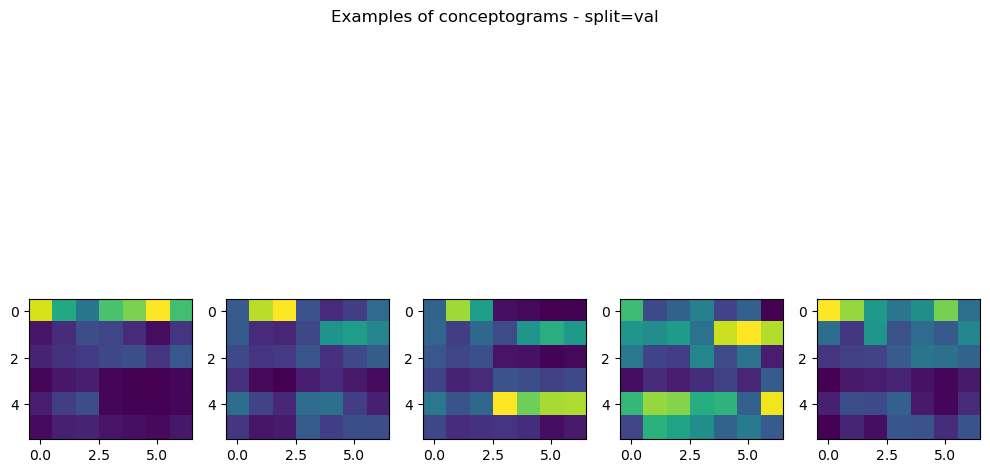

In [61]:
split = 'val'

n_cgs = 5

fig, axs = plt.subplots(1, n_cgs, figsize=(10, 7))
fig.suptitle(f'Examples of conceptograms - split={split}\n')
for i in range(n_cgs):
    axs[i].imshow(cgs_dict[split][i].detach().cpu().numpy().T)
    
plt.tight_layout()

In [84]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

    def imshow(self, im):
        im = self(im)
        im = im.detach().cpu().numpy().transpose(1, 2, 0)
        return np.clip(im, 0, 1)

In [85]:
mean = [0.6672, 0.5293, 0.5234]
std = [0.2237, 0.2035, 0.2152]
unorm = UnNormalize(mean, std)

In [95]:
mapping.mapping

{'NV': 0, 'MEL': 1, 'BKL': 2, 'SCC': 3, 'BCC': 4, 'AK': 5}

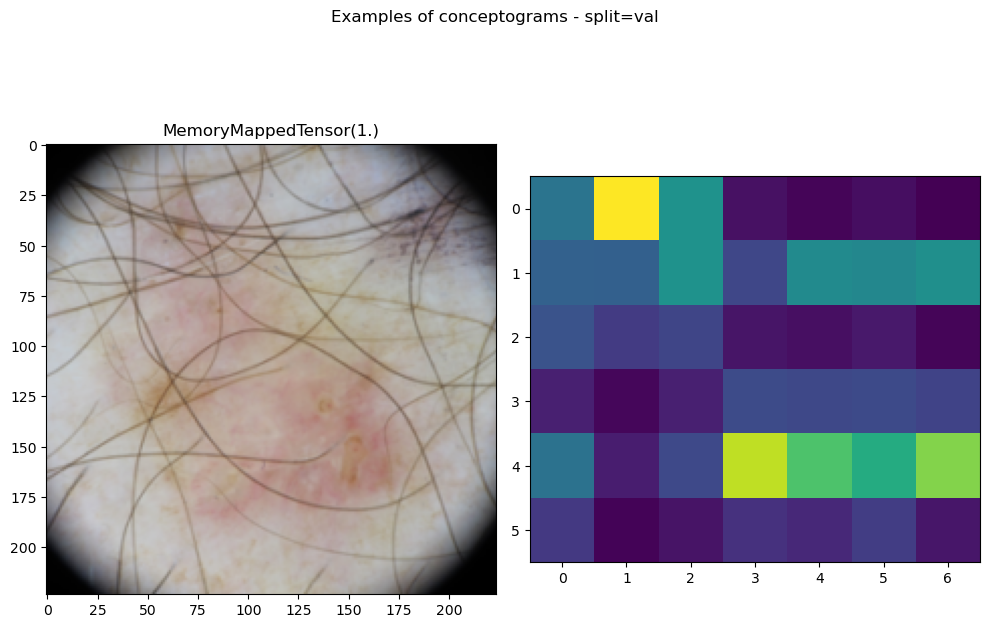

In [93]:
split = 'val'

n_plots = 1

n_cg = np.random.randint(0, len(ds[split]['image']), n_plots)
# n_cg  = [4628]

fig, axs = plt.subplots(n_plots, 2, figsize=(10, 7), squeeze=False)

fig.suptitle(f'Examples of conceptograms - split={split}\n')
for i, ax in zip(n_cg, axs):
    ax[0].imshow(unorm.imshow(ds[split]['image'][i]))
    ax[1].imshow(cgs_dict[split][i].detach().cpu().numpy().T)
    ax[0].set(title=f'{ds[split]['label'][i]}')
    
plt.tight_layout()


In [87]:
i

4628

### All configurations

In [57]:
cls_type = 'tGMM' # 'tGMM' or the classifier you used to generate peepholes

In [64]:
config_names

{'peepholes_nevi_diagnosis.classifier.0',
 'peepholes_nevi_diagnosis.classifier.3',
 'peepholes_nevi_diagnosis.classifier.6',
 'peepholes_nevi_diagnosis.classifier.9',
 'peepholes_nevi_diagnosis.features.24',
 'peepholes_nevi_diagnosis.features.26',
 'peepholes_nevi_diagnosis.features.28'}

In [58]:
splits = ['train', 'test', 'val']

    
entries = phs_path.iterdir()
config_names = {'.'.join(entry.name.split('.')[:-1]) for entry in entries}
if '' in config_names: config_names.discard('')

# load scores
ph_dict = {}
for ph_config_name in config_names:
    peepholes = Peepholes(
        path=phs_path,
        name=ph_config_name,
        classifier=None,
        layer=target_layers,
        device=device
    )
    with peepholes as ph:
        ph.load_only(loaders=splits, verbose=False)
        for split in splits:
            ph_dict.setdefault(ph_config_name, {})[split] = ph._phs[split].detach().cpu().numpy()

closing train
closing test
closing val
closing train
closing test
closing val
closing train
closing test
closing val
closing train
closing test
closing val
closing train
closing test
closing val
closing train
closing test
closing val
closing train
closing test
closing val


In [60]:
# ph_dict

### Tuning

__How to select a configuration?__
One possible criterion is to evaluate each single layer so that we reject the least possible number of inputs to reach a target accuracy.
We can store information about the relative `peep_size, n_clusters)` in a `pd.DataFrame` to automate the selection of peephole from the above `ph_dict`.

In [61]:
# sm = {}
# se = {}
# delta = 0.02 # target increase in accuracy

# for ph_config_name in set(config_names):
#     sm[ph_config_name] = {}
#     se[ph_config_name] = {}

#     for split in splits:
#         sm[ph_config_name][split] = {}
#         se[ph_config_name][split] = {}

#         for layer in target_layers:
#             if layer not in ph_dict[ph_config_name][split] or layer not in ph_dict[ph_config_name][split].keys():
#                 #print(f"Skipping missing layer: {layer} for config {ph_config_name}")
#                 continue
#             else:
#                 sm[ph_config_name][split][layer] = ph_dict[ph_config_name][split][layer]['score_max']
#                 se[ph_config_name][split][layer] = ph_dict[ph_config_name][split][layer]['score_entropy']

In [62]:
# res_name = f'results_tuning_{cls_type}.csv'
# results_path = results_dir / res_name

# # check if the tuning results file already exists
# if results_path.exists():
#     print(f'Results file {res_name} already exists. Loading existing results.')
#     results_df = pd.read_csv(results_path)
# else:
#     results = []

#     # loop over score types ('max', 'entropy') for evaluation
#     for score_type in ['max', 'entropy']:
#         split = 'val'

#         # initialize dictionaries to store evaluation results
#         eval_max = {}
#         eval_entropy = {}

#         # iterate over unique configurations
#         for i, ph_config_name in enumerate(set(config_names)):
#             peep_size = ph_config_name.split('.')[1]
#             n_cls = ph_config_name.split('.')[2]

#             # evaluate for each target layer
#             for j, layer in enumerate(target_layers):
#                 if layer not in sm[ph_config_name][split] or layer not in se[ph_config_name][split]:
#                     continue
                
#                 # get data based on score type
#                 if score_type == 'max':
#                     data = sm[ph_config_name][split][layer]
#                 else:
#                     data = se[ph_config_name][split][layer]
                
#                 # skip if data contains only NaN values
#                 if np.isnan(data).all():
#                     continue

#                 # create a DataFrame for evaluation
#                 df_eval = pd.DataFrame()
#                 df_eval[score_type] = data
#                 df_eval['result'] = out_df['result'].values
#                 df_sorted = df_eval.sort_values(by=score_type, ascending=False)

#                 # calculate initial accuracy and target accuracy
#                 acc_ini = df_sorted['result'].sum() / len(df_sorted)
#                 target_acc = acc_ini + delta  # `delta` is predefined
#                 num_to_remove = eval_acc(df_sorted, target_acc)  # `eval_acc` is a function in `nb_utils.py`

#                 # store evaluation result based on score type
#                 if score_type == 'max':
#                     eval_max[(peep_size, n_cls, layer)] = num_to_remove
#                 else:
#                     eval_entropy[(peep_size, n_cls, layer)] = num_to_remove

#         # select the appropriate dictionary for results
#         if score_type == 'max':
#             res_dict = eval_max
#         else:
#             res_dict = eval_entropy

#         # convert the results to a DataFrame
#         df = pd.DataFrame(
#             list(res_dict.items()),
#             columns=["config", "num_to_remove"]
#         )

#         # split the 'config' column into separate columns for peep_size, n_cls, and layer
#         df[["peep_size", "n_cls", "layer"]] = pd.DataFrame(df["config"].tolist(), index=df.index)
#         df = df.drop(columns=["config"])
#         df = df.set_index(["peep_size", "n_cls", "layer"])

#         print(f'score_type: {score_type} - cls: {cls_type}')

#         # evaluate results for each layer
#         for layer in target_layers:
#             layer_df = df.xs(layer, level='layer')

#             # define output path for each layer's results
#             layer_output_path = results_dir / f"eval_{cls_type}_{score_type}_layer_{layer}.csv"
#             layer_df.to_csv(layer_output_path)

#             # find the configuration with the minimum 'num_to_remove' value
#             min_config = layer_df['num_to_remove'].idxmin()
#             min_value = layer_df['num_to_remove'].min()

#             # calculate the percentage of elements removed
#             percent_removed = min_value / len(out_df['result'].values)

#             # append the results for later use
#             results.append({
#                 'score_type': score_type,
#                 'cls_type': cls_type,
#                 'layer': layer,
#                 'best_config': min_config,
#                 'percent_removed': percent_removed
#             })

#     # convert the results list to a DataFrame
#     results_df = pd.DataFrame(results)

#     # save the final results DataFrame to a CSV file
#     results_df.to_csv(results_path, index=False)

#     print(f"Results saved to {results_path}.")

In [63]:
# results_df.style.background_gradient(subset=['percent_removed'], cmap='viridis')

### Custom configurations
If you just want to make some trials... you can skip tuning and do something like this:

In [131]:
n_layers = len(target_layers)

score_type_values = ['max'] * n_layers # assuming score_type is the same for all rows
cls_type_values = [cls_type] * n_layers  # assuming cls_type is the same for all rows
layer_values = target_layers # or a subset of layers of your interest

best_config_values = [('64', '512'), ('64', '512'), ('300', '512'), ('256', '512'), ('256', '256')] # hard coded
best_config_values = [()]
# or randomly selected from the available configurations
unique_configs = set((ph_config_name.split('.')[1], ph_config_name.split('.')[2]) for ph_config_name in config_names)
selected_configs = random.sample(list(unique_configs), n_layers)
best_config_values = [tuple(config) for config in selected_configs]

In [134]:
custom_df = pd.DataFrame({
    'score_type': score_type_values,
    'cls_type': cls_type_values,
    'layer': layer_values,
    'best_config': best_config_values
})

custom_df

,score_type,cls_type,layer,best_config
0,max,tKMeans,features.24,"(16, 128)"
1,max,tKMeans,features.26,"(32, 256)"
2,max,tKMeans,features.28,"(16, 16)"
3,max,tKMeans,classifier.0,"(256, 100)"
4,max,tKMeans,classifier.3,"(128, 128)"


### Peephole Selection

#### Utils

In [26]:
#import ast

def collect_ph_sel(ph_dict, results_df, split):
    ph_sel = {}
    
    for _, row in results_df.iterrows():
        score_type = row['score_type']
        cls_type = row['cls_type']
        layer = row['layer']
        
        # check if 'best_config' is a string and use literal_eval only if it is
        best_config = row['best_config']
        if isinstance(best_config, str):
            peep_size, n_cls = ast.literal_eval(best_config)
        else:
            peep_size, n_cls = best_config  # assuming it's already a tuple or list

        # initialize nested dictionary structure if needed
        if score_type not in ph_sel:
            ph_sel[score_type] = {}
        if cls_type not in ph_sel[score_type]:
            ph_sel[score_type][cls_type] = {}
        
        # construct the configuration name and retrieve data
        ph_config_name = f'peepholes.{peep_size}.{n_cls}'
        data = ph_dict[ph_config_name][split][layer]['peepholes']
        
        # store the data in the dictionary
        ph_sel[score_type][cls_type][layer] = data

    return ph_sel


In [75]:
# can be useful if you want to build a DataLoader of conceptograms
class PhDataset(Dataset):
    def __init__(self, data, labels):
        '''
        Args:
            data (numpy array): Array of shape (num_samples, height, width).
            labels (numpy array): Binary labels of shape (num_samples,).
        '''
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

#### Selection
Here you can use the `results_df` that is based on tuning or your `custom_df`.

In [29]:
ph_sel_train = collect_ph_sel(ph_dict, results_df, 'train')
ph_sel_val = collect_ph_sel(ph_dict, results_df, 'val')
ph_sel_test = collect_ph_sel(ph_dict, results_df, 'test')

## Conceptograms

In [31]:
ph_sel_dicts = {'train': ph_sel_train, 'val': ph_sel_val, 'test': ph_sel_test}
ds_len = {'train': 40000, 'val': 10000, 'test': 10000}
score_type = 'max'

include_o_dnn = False # choose whether to include the output of the NN in the conceptograms

cgs = {}

for split, ph_sel in ph_sel_dicts.items():

    conceptograms = [] # peepholes only
    
    for i in range(ds_len[split]):
        ph_comb = []
        for layer in target_layers:
            ph = ph_sel[score_type][cls_type][layer][i]
            ph_comb.append(ph)
                
        cg = np.concatenate([ph_comb], axis=1).T
        if split != 'train':
            if include_o_dnn:
                ph_wdnn = np.concatenate([cg, o_dnn[split][i].reshape(-1, 1)], axis=1)
                conceptograms.append(ph_wdnn)
            else:
                conceptograms.append(cg)
    
    conceptograms = np.array(conceptograms)

    cgs[split] = conceptograms

In [32]:
cgs['val'][0].shape

(100, 5)

### Visualization

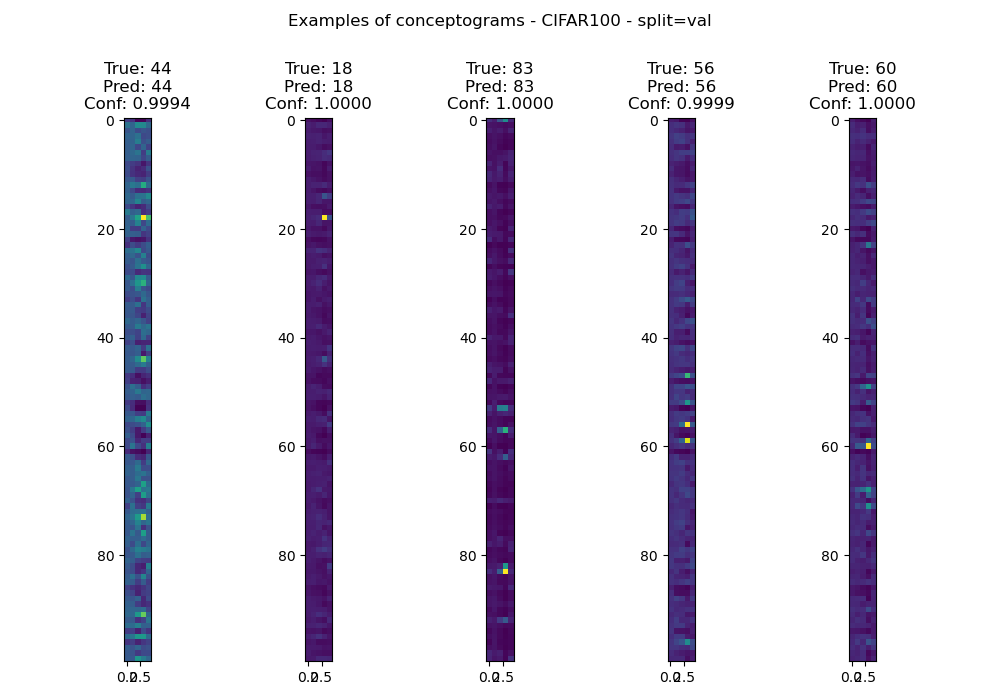

In [33]:
split = 'val'

n_cgs = 5

fig, axs = plt.subplots(1, n_cgs, figsize=(10, 7))
fig.suptitle(f'Examples of conceptograms - {dataset} - split={split}\n')
for i in range(n_cgs):
    axs[i].imshow(cgs[split][i])
    axs[i].set_title(f'True: {int(true[split][i])}\nPred: {int(pred[split][i])}\nConf: {o_dnn_dfs[split]['max'][i]:.4f}')

plt.tight_layout()

In [61]:
import sklearn
#import imblearn

print("scikit-learn version:", sklearn.__version__)
#print("imbalanced-learn version:", imblearn.__version__)

scikit-learn version: 1.5.2


In [62]:
from imblearn.over_sampling import SMOTE

ImportError: cannot import name 'get_tags' from 'sklearn.utils' (/srv/newpenny/conda/envs/xai-venv/lib/python3.12/site-packages/sklearn/utils/__init__.py)

In [55]:
smote = SMOTE(sampling_strategy=1.0, random_state=42)  # make class 1 same size as class 0
X_resampled, y_resampled = smote.fit_resample(balanced_train_x, balanced_train_y)

# convert to PyTorch tensors
#train_x = torch.tensor(X_resampled, dtype=torch.float32)
#train_y = torch.tensor(y_resampled, dtype=torch.long)

NameError: name 'SMOTE' is not defined

In [34]:
classes = ds.get_classes()

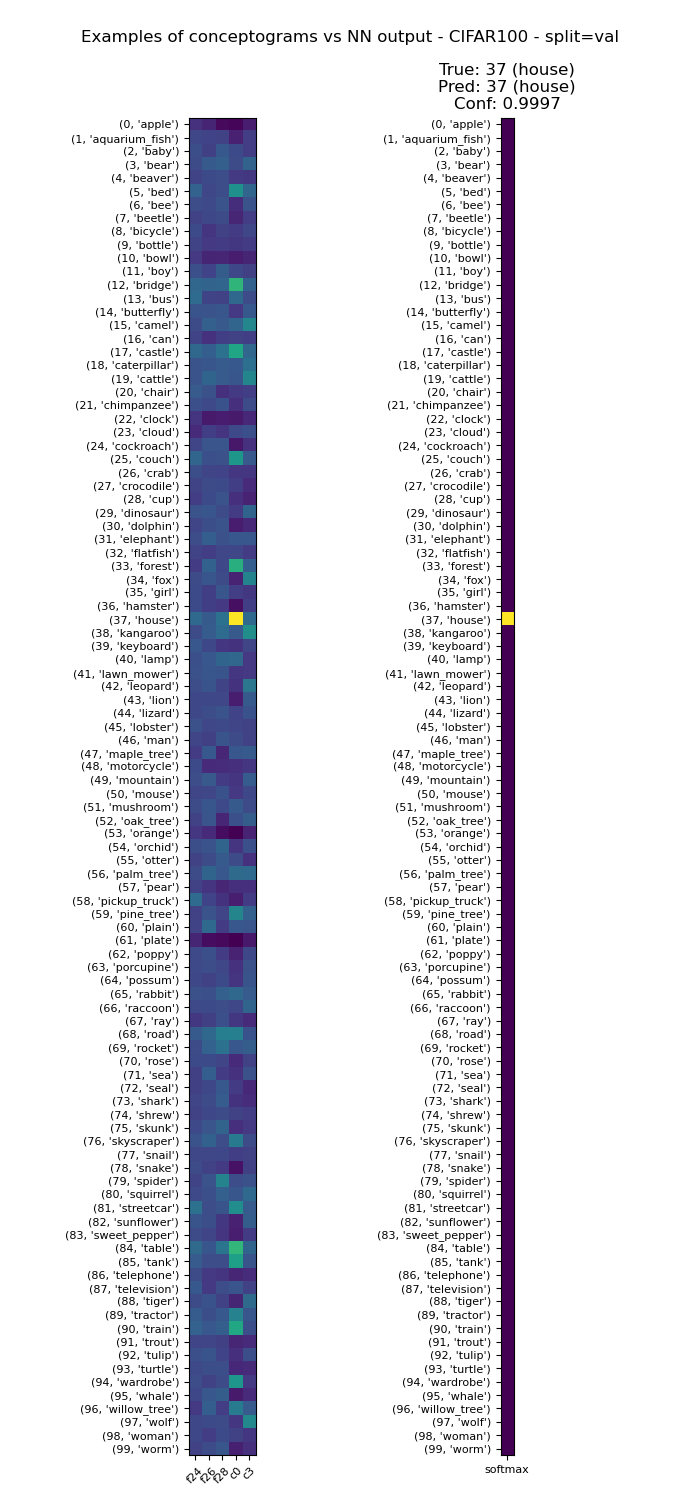

In [35]:
split = 'val'

idx = 50

x_labels = ['f24', 'f26', 'f28', 'c0', 'c3']
y_labels = list(ds.get_classes().keys())

fig, axs = plt.subplots(1, 2, figsize=(7, 15))
fig.suptitle(f'Examples of conceptograms vs NN output - {dataset} - split={split}\n')

axs[0].imshow(cgs[split][idx])

true_l = int(true[split][idx])
pred_l = int(pred[split][idx])
conf = o_dnn_dfs[split]['max'][idx]
axs[1].set_title(f'True: {true_l} ({classes[true_l]})\nPred: {pred_l} ({classes[pred_l]})\nConf: {conf:.4f}')
axs[1].imshow(o_dnn[split][idx].reshape(-1, 1))

axs[0].set_xticks(range(len(x_labels)))
axs[0].set_xticklabels(x_labels, fontsize=8, rotation=45)
axs[0].set_yticks(y_labels)
axs[0].set_yticklabels(list(classes.items()), fontsize=8)

axs[1].set_xticks([0])
axs[1].set_xticklabels(['softmax'], fontsize=8)
axs[1].set_yticks(y_labels)
axs[1].set_yticklabels(list(classes.items()), fontsize=8)

plt.tight_layout()